# Dive Prediction - First Time Passage

*Predicting Seabird Diving Behaviour from GPS data*

This notebook predicts dive with First Time Passage Approach

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

from utils.trip import * 

In [2]:
data_test = pd.read_csv('./../data/SV_test_guanape.csv')

## Choose resolution

In [3]:
resolution = 5
data_test_new = change_resolution(data_test, resolution)
data_test_new = standardize_data(data_test_new)

data_test_new

,trip,datetime,lon,lat,gaps,dive,step_speed,step_direction,lon_std,lat_std,step_speed_std,step_direction_cos,step_direction_sin
2,G1107_12_SV_T1,2007-11-19 13:42:28,-78.958106,-8.567359,0.0,0,8.306816,14.473134,1.917377,2.293521,0.412817,0.968265,0.249926
3,G1107_12_SV_T1,2007-11-19 13:42:33,-78.958196,-8.567769,0.0,0,9.340164,10.728200,1.916609,2.289293,0.464307,0.982521,0.186150
4,G1107_12_SV_T1,2007-11-19 13:42:38,-78.958359,-8.568248,0.0,0,11.251253,6.351008,1.915217,2.284353,0.559533,0.993863,0.110619
5,G1107_12_SV_T1,2007-11-19 13:42:43,-78.958489,-8.568707,0.0,0,10.611651,-2.952198,1.914107,2.279619,0.527663,0.998673,-0.051503
6,G1107_12_SV_T1,2007-11-19 13:42:48,-78.958627,-8.569070,0.0,0,8.633423,4.956724,1.912928,2.275875,0.429091,0.996260,0.086403
...,...,...,...,...,...,...,...,...,...,...,...,...,...
53434,G1107_9_SV_T1,2007-11-18 17:41:44,-78.965941,-8.567722,0.0,0,9.524216,28.485340,-1.557992,2.058812,0.394356,0.878939,0.476934
53435,G1107_9_SV_T1,2007-11-18 17:41:49,-78.965598,-8.567170,0.0,0,14.423293,-73.885990,-1.552501,2.063090,0.598714,0.277550,-0.960711
53436,G1107_9_SV_T1,2007-11-18 17:41:54,-78.965450,-8.566270,0.0,0,20.299387,-22.332355,-1.550132,2.070065,0.843827,0.924995,-0.379979
53437,G1107_9_SV_T1,2007-11-18 17:41:59,-78.965760,-8.565544,0.0,0,17.544234,-32.127179,-1.555095,2.075691,0.728900,0.846870,-0.531800


## Empirical parameters 

In [4]:
## compute distance matrixes
list_trip = []
for i in data_test_new.trip.unique():
    t = data_test_new[data_test_new.trip == i]
    
    trip = Trip(t)
    trip.compute_dist_matrix()
    list_trip.append(trip)

In [5]:
## compute first time passage
radius = 500

list_ftp = []
for trip in list_trip:
    ftp = trip.first_time_passage(radius)
    ftp = ftp/max(ftp)
    ftp[ftp < 1e-5] = 1e-5
    ftp[ftp > 1-1e-5] = 1-1e-5
    
    list_ftp.append(ftp)

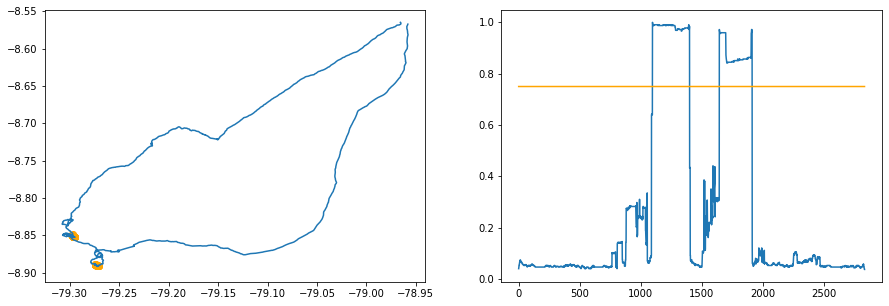

In [6]:
time_threshold = 0.75

i = 0

trip = list_trip[i]
ftp = list_ftp[i]

plt.figure(figsize = (15, 5))
plt.subplot(1,2,1)
plt.plot(np.array(trip.df.lon), np.array(trip.df.lat))
plt.scatter(trip.df.lon.values[ftp>time_threshold], \
            trip.df.lat.values[ftp>time_threshold], c = 'orange')

plt.subplot(1,2,2)
plt.plot(ftp)
plt.plot(time_threshold*np.ones(len(ftp)), c = 'orange')

In [7]:
data_test_new['prediction'] = np.hstack(list_ftp)
data_test_new.to_csv('./../results/SV_ftp_GNP.csv', index = False)

## compute loss

In [8]:
def loss(x, y, weight):
    return np.mean(-(weight*y*np.log(x) + (1-y)*np.log(1-x)))

In [9]:
loss(data_test_new.prediction, data_test_new.dive, 30)

0.8154037059408044